# OddsJam EV Filter Analysis — Preprocessing QA + Initial EDA (Notebook 01)

## Purpose
This notebook performs **initial EDA and diagnostics** on an analysis-ready OddsJam Bet Tracker dataset.

**Important:** raw preprocessing + QA are executed via `scripts/preprocess_bet_tracker.py`, which writes a dated parquet to `data/processed/`.  
This notebook **reads that parquet directly** and focuses on validation plots, summaries, and early insights to guide downstream notebooks.

## Preprocessing Workflow (Script → Notebook)
1. Run preprocessing + QA (writes parquet + artifacts):
   - `poetry run python scripts/preprocess_bet_tracker.py --config configs/preprocess.yaml`
2. Open this notebook to load the processed parquet and run EDA.

## Outputs (Notebook 01)
- Filter-level summary tables (profit, ROI, EV ROI, bet counts)
- Diagnostic plots (expected vs actual ROI, cumulative profit, bet timing patterns)
- QA artifacts produced by the preprocessing script (saved under `data/processed/artifacts/`), e.g.:
  - `field-validation-{AS_OF_DATE}.json` (missingness + impossible values)
  - `duplicate-audit-{AS_OF_DATE}.csv` (duplicates under multiple key schemes)
  - `liquidity-meta-{AS_OF_DATE}.json` (liquidity bucketing metadata)
  - (optional) `status-summary-{AS_OF_DATE}.csv` + `settled-statuses-{AS_OF_DATE}.json`

## Notes / Assumptions
- `created_at` is standardized to ET (`America/New_York`) in preprocessing:
  - tz-naive timestamps are localized to ET (assumption should match how OddsJam exported)
- Profit is assumed to be in `bet_profit` and stake in `stake`
- Saved filter names are standardized into `saved_filter_names`
- Duplicates are preserved by default to reflect true execution/realized ROI (artifact-dedupe is optional and OFF)
- Liquidity may be missing for sportsbooks/older exports; buckets can be inferred from `tags` when present (fallback)

## Environment + Imports
This section sets notebook display preferences, establishes the analysis date, and imports plotting + QA helpers from `oddsjam_ev`.

In [ ]:
from __future__ import annotations

# for high res plots
%config InlineBackend.figure_format = 'svg'

# automatically reload modules when they change on disk
%load_ext autoreload
%autoreload 2

In [2]:
import platform
import sys

sys.executable, platform.python_version()

('/Users/jniederer/projects/betting/oddsjam-ev-filters/.venv/bin/python',
 '3.11.7')

In [ ]:
import datetime as dt
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from oddsjam_ev.plotting import (
    AvgBetsByTimeBucketPlotConfig,
    BetCountOverTimePlotConfig,
    # EV bucket plots
    CombinedEVPlotConfig,
    CumProfitByGroupPlotConfig,
    # Time-series / activity plots
    CumProfitPlotConfig,
    ProfitByGroupPlotConfig,
    # ROI scatter / filter plots
    RoiScatterConfig,
    combined_ev_summary_plot,
    combined_ev_summary_plot_faceted_by_group,
    plot_avg_bets_by_time_bucket,
    plot_bet_count_over_time,
    plot_cum_profit_by_group,
    plot_cum_profit_top_filters,
    plot_filter_roi_scatter,
    plot_profit_by_group_for_filters,
)

In [4]:
pd.set_option("display.max_columns", None)  # show all columns
pd.set_option("display.max_colwidth", None)  # don’t truncate column values
pd.set_option("display.width", None)  # let Pandas use full available width

## Load Processed Dataset
Loads the canonical processed parquet written by `scripts/preprocess_bet_tracker.py`.
If this file is missing, run preprocessing first.

In [5]:
AS_OF_DATE = "02-06-2026"
CURRENT_DT = dt.datetime.today().strftime("%m-%d-%Y")
print(f"AS_OF_DATE: {AS_OF_DATE}, CURRENT_DT: {CURRENT_DT}")

AS_OF_DATE: 02-06-2026, CURRENT_DT: 02-10-2026


In [6]:
processed_path = Path("../data/processed") / f"oddsjam-bet-tracker-processed-{AS_OF_DATE}.parquet"
if not processed_path.exists():
    raise FileNotFoundError(
        f"Missing {processed_path}. Run:\n"
        "  poetry run python scripts/preprocess_bet_tracker.py --config configs/preprocess.yaml"
    )

df_filtered = pd.read_parquet(processed_path)
print("Loaded:", processed_path.resolve())
print(f"Rows: {len(df_filtered):,}")
df_filtered.head()

Loaded: /Users/jniederer/projects/betting/oddsjam-ev-filters/data/processed/oddsjam-bet-tracker-processed-02-06-2026.parquet
Rows: 34,348


,created_at,sportsbook,sport,league,event_name,game_id,event_start_date,market_name,bet_name,odds,clv,clv_source,stake,potential_payout,status,bet_type,bet_profit,notes,is_live_bet,is_free_bet,is_odds_boost,percentage,liquidity,market_width,saved_filter_names,parlay_id,tags,created_at_et,created_at_est,liquidity_bucket,time_to_event_bucket,prob_odds,odds_multiplier,prob_clv,ev,ev_roi
0,2025-03-22 00:30:25,Novig,basketball,NBA,Denver Nuggets vs Portland Trail Blazers,54023-38874-2025-03-21,2025-03-22 02:00:00,Player Points + Rebounds + Assists,Russell Westbrook Over 32.5,115.0,112.0,OddsJam Algo Odds,350.0,752.5,lost,positive_ev,-350.0,None,False,False,False,7.98,NaN,30.0,Betting Exchanges & Offshore Sportsbooks: OddsJam Recommended Filters,NaN,None,2025-03-22 00:30:25-04:00,2025-03-22 00:30:25-04:00,None,2 - 4 hours,0.465116,1.15,0.471698,4.952830,0.014151
1,2025-03-22 00:30:32,Novig,basketball,NBA,Boston Celtics vs Utah Jazz,77646-40177-2025-03-21,2025-03-22 01:30:00,Player Points,Brice Sensabaugh Over 10.5,110.0,114.0,OddsJam Algo Odds,270.0,567.0,lost,positive_ev,-270.0,None,False,False,False,5.94,NaN,30.0,Betting Exchanges & Offshore Sportsbooks: OddsJam Recommended Filters,NaN,None,2025-03-22 00:30:32-04:00,2025-03-22 00:30:32-04:00,None,<= 1 hour,0.476190,1.10,0.467290,-5.046729,-0.018692
2,2025-03-22 00:30:40,Prophet X,basketball,NBA,Cleveland Cavaliers vs Phoenix Suns,11464-24860-2025-03-21,2025-03-22 02:00:00,Player Points,Devin Booker Over 26.5,105.0,104.0,OddsJam Algo Odds,270.0,553.5,lost,positive_ev,-270.0,None,False,False,False,5.72,NaN,30.0,Betting Exchanges & Offshore Sportsbooks: OddsJam Recommended Filters,NaN,None,2025-03-22 00:30:40-04:00,2025-03-22 00:30:40-04:00,None,2 - 4 hours,0.487805,1.05,0.490196,1.323529,0.004902
3,2025-03-22 00:30:48,Novig,basketball,NBA,Boston Celtics vs Utah Jazz,77646-40177-2025-03-21,2025-03-22 01:30:00,Player Points + Rebounds + Assists,Derrick White Over 27.5,110.0,108.0,OddsJam Algo Odds,230.0,483.0,lost,positive_ev,-230.0,None,False,False,False,5.00,NaN,30.0,Betting Exchanges & Offshore Sportsbooks: OddsJam Recommended Filters,NaN,None,2025-03-22 00:30:48-04:00,2025-03-22 00:30:48-04:00,None,<= 1 hour,0.476190,1.10,0.480769,2.211538,0.009615
4,2025-03-22 00:31:04,Novig,basketball,NBA,Boston Celtics vs Utah Jazz,77646-40177-2025-03-21,2025-03-22 01:30:00,Player Points + Rebounds + Assists,Derrick White Over 27.5,110.0,108.0,OddsJam Algo Odds,230.0,483.0,lost,positive_ev,-230.0,None,False,False,False,5.00,NaN,30.0,Betting Exchanges & Offshore Sportsbooks: OddsJam Recommended Filters,NaN,None,2025-03-22 00:31:04-04:00,2025-03-22 00:31:04-04:00,None,<= 1 hour,0.476190,1.10,0.480769,2.211538,0.009615


In [7]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34348 entries, 0 to 34347
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype                           
---  ------                --------------  -----                           
 0   created_at            34348 non-null  datetime64[ns]                  
 1   sportsbook            34348 non-null  object                          
 2   sport                 34348 non-null  object                          
 3   league                34348 non-null  object                          
 4   event_name            32564 non-null  object                          
 5   game_id               34348 non-null  object                          
 6   event_start_date      34348 non-null  object                          
 7   market_name           34348 non-null  object                          
 8   bet_name              34348 non-null  object                          
 9   odds                  34348 non-null  float64     

## Load QA Artifacts
Loads preprocessing artifacts (field validation, liquidity metadata, settlement summary) from `data/processed/artifacts/`.
These are used to cross-check that the notebook’s diagnostics match what the script observed at ingest time.

In [8]:
# --- Load latest QA artifacts ---
art_dir = Path("../data/processed/artifacts")

liq_meta_files = sorted(art_dir.glob(f"liquidity-meta-{AS_OF_DATE}.json"))
field_val_files = sorted(art_dir.glob(f"field-validation-{AS_OF_DATE}.json"))
settled_files = sorted(art_dir.glob(f"settled-statuses-{AS_OF_DATE}.json"))

liq_meta = json.loads(liq_meta_files[-1].read_text()) if liq_meta_files else {}
filt_core = json.loads(field_val_files[-1].read_text()) if field_val_files else {}
settled_meta = json.loads(settled_files[-1].read_text()) if settled_files else {}

print("liq_meta keys:", list(liq_meta.keys())[:20])
print("field_validation keys:", list(filt_core.keys())[:20])
print("settled_statuses keys:", list(settled_meta.keys())[:20])

liq_meta keys: ['n_rows', 'numeric_used_n', 'numeric_used_rate', 'tag_used_n', 'tag_used_rate', 'still_missing_n', 'still_missing_rate', 'condensed']
field_validation keys: ['n_rows', 'missing_rate', 'impossible_counts']
settled_statuses keys: ['as_of_date', 'run_id', 'profit_known_threshold', 'exclude_statuses_for_settled_inference', 'exclude_statuses_from_processed', 'settled_statuses', 'n_rows_processed', 'n_rows_settled', 'processed_all_settled', 'settled_written']


In [9]:
# Ensure 'No Filter' label is present for null filters
no_filter_df = df_filtered.loc[df_filtered["saved_filter_names"].eq("No Filter")].copy()
print(f"No Filter rows: {len(no_filter_df):,}")

stake_num = pd.to_numeric(no_filter_df["stake"], errors="coerce")
profit_num = pd.to_numeric(no_filter_df["bet_profit"], errors="coerce")

no_filter_summary = {
    "min_date": no_filter_df["created_at_est"].min(),
    "max_date": no_filter_df["created_at_est"].max(),
    "total_stake": float(stake_num.sum(skipna=True)),
    "total_profit": float(profit_num.sum(skipna=True)),
}

for k, v in no_filter_summary.items():
    print(f"{k}: {v}")

No Filter rows: 8,740
min_date: 2025-03-22 00:35:49-04:00
max_date: 2026-02-05 20:38:00-05:00
total_stake: 446471.72
total_profit: -28065.51


## Duplicate Audit Exploration
Duplicates are preserved by default (no dedupe) because repeated execution can be real signal.
This section surfaces the “worst” duplicate key scheme and inspects example clusters.

In [10]:
# --- Inspect example duplicate clusters for the worst-performing key scheme ---

ARTIFACTS_DIR = Path("../data/processed/artifacts")
dupe_report = pd.read_csv(ARTIFACTS_DIR / f"duplicate-audit-{AS_OF_DATE}.csv")

worst = (
    dupe_report.dropna(subset=["dupe_row_rate"])
    .sort_values("dupe_row_rate", ascending=False)
    .head(1)
)
if worst.empty:
    print("No duplicate schemes were evaluable (likely missing key columns).")
else:
    key_name = worst["key_name"].iloc[0]
    cols = [c.strip() for c in key_name.split("|") if c.strip()]
    cols = [c for c in cols if c in df_filtered.columns]

    print("Worst duplicate key scheme:", key_name)

    if not cols:
        print("None of the key columns are present in df_filtered.")
    else:
        dupe_mask = df_filtered.duplicated(subset=cols, keep=False)

        show_cols = cols + ["created_at_et", "saved_filter_names", "stake", "odds", "bet_profit"]
        show_cols = list(dict.fromkeys([c for c in show_cols if c in df_filtered.columns]))

        sort_cols = list(
            dict.fromkeys(
                cols + (["created_at_et"] if "created_at_et" in df_filtered.columns else [])
            )
        )

        example = df_filtered.loc[dupe_mask, show_cols].sort_values(sort_cols).head(20)
        display(example)

Worst duplicate key scheme: sportsbook | created_at_et | stake | odds | bet_profit


,sportsbook,created_at_et,stake,odds,bet_profit,saved_filter_names
19744,DraftKings (Pick 3),2025-10-21 22:38:55-04:00,50.00,-153.0,-50.00,No Filter
19746,DraftKings (Pick 3),2025-10-21 22:38:55-04:00,50.00,-153.0,-50.00,No Filter
2100,Novig,2025-03-27 22:31:25-04:00,3.09,119.0,3.68,No Filter
2101,Novig,2025-03-27 22:31:25-04:00,3.09,119.0,3.68,No Filter
2103,Novig,2025-03-27 22:31:27-04:00,3.09,119.0,3.68,No Filter
2104,Novig,2025-03-27 22:31:27-04:00,3.09,119.0,3.68,No Filter
2111,Novig,2025-03-27 22:32:34-04:00,2.31,-154.0,-2.31,No Filter
2112,Novig,2025-03-27 22:32:34-04:00,2.31,-154.0,-2.31,No Filter
2931,Novig,2025-03-30 17:18:48-04:00,1.03,-101.0,-1.03,No Filter
2932,Novig,2025-03-30 17:18:48-04:00,1.03,-101.0,-1.03,No Filter


In [11]:
# Ensure labels are present
df_filtered["saved_filter_names"] = df_filtered["saved_filter_names"].fillna("No Filter")

# Keep only filters with >= 100 bets
counts = df_filtered["saved_filter_names"].value_counts(dropna=False)
keep = counts[counts >= 100].index
df_eda = df_filtered[df_filtered["saved_filter_names"].isin(keep)].copy()

print("Remaining filters:", df_eda["saved_filter_names"].nunique())
df_eda["saved_filter_names"].value_counts()

Remaining filters: 17


saved_filter_names
No Filter                                                                        8740
PROD - Exchanges: Core Exchange Conservative (Low Risk, Slow Build)              7266
TEST - Exchanges: OddsJam Recommended Filters (OddsJam Power Devig)              3297
TEST - Exchanges: OddsJam Recommended Filters (OddsJam Worst Case Devig)         3207
TEST - Exchanges: OddsJam Recommended Filters Next 7 Days                        3063
PROD - Offshore Books: Core & Conservative (Low Risk, Slow Build)                2375
PROD - DFS/Sweepstakes: OddsJam Recommended Filters Next 7 Days                  1700
TEST - Exchanges & Offshore Books:  Alex Monahan Suggested Filters                995
TEST - Offshore Books: OddsJam Recommended Filters (OddsJam Power Devig)          797
TEST - Offshore Books: OddsJam Recommended Filters (OddsJam Worst Case Devig)     760
TEST - Exchanges: Underdog Edge hunter (Behavioral Inefficiency)                  538
TEST - Offshore Books: OddsJam Reco

In [12]:
df_filtered["sportsbook"].value_counts()

sportsbook
Novig                             15638
Prophet X                          8072
BookMaker                          2738
BetOnline                          1336
Rebet Props City                   1038
Underdog Fantasy (3 or 5 Pick)      934
OwnersBox                           844
4Cx                                 548
bet105                              496
BetOpenly                           464
MyBookie                            454
Onyx Odds                           418
Kalshi                              265
Thrillzz                            222
Rebet                               189
BetUS                               180
Bracco                              155
BetDSI (Superbook)                  123
BetAnySports                        103
Sportzino                           101
Robinhood                            14
DraftKings (Pick 3)                   6
BetDSI                                3
Xbet                                  3
ParlayPlay                   

In [13]:
# --- Liquidity buckets ---

# If you kept liq_meta from the script artifacts, use it:
try:
    display(liq_meta)
except NameError:
    print("liq_meta not found in notebook. (Load liquidity-meta artifact JSON if needed.)")

# If columns exist (future-proof), print them; otherwise don't crash
for col in ["liquidity_source", "liquidity_bucket"]:
    if col in df_filtered.columns:
        print(f"\n{col} breakdown:")
        print(df_filtered[col].value_counts(dropna=False).head(30))
    else:
        print(f"\n{col} not present in df_filtered (expected with current add_liquidity_bucket).")

print(
    "\nFinal liquidity_bucket missing rate:", float(df_filtered["liquidity_bucket"].isna().mean())
)

{'n_rows': 36529,
 'numeric_used_n': 0,
 'numeric_used_rate': 0.0,
 'tag_used_n': 9237,
 'tag_used_rate': 0.25286758465876424,
 'still_missing_n': 27292,
 'still_missing_rate': 0.7471324153412358,
 'condensed': {'enabled': True,
  'labels': ['<=500', '500-1k', '1k-2k', '2k-5k', '5k-10k', '>10k'],
  'edges': [-inf, 500.0, 1000.0, 2000.0, 5000.0, 10000.0, inf]}}


liquidity_source not present in df_filtered (expected with current add_liquidity_bucket).

liquidity_bucket breakdown:
liquidity_bucket
None      25193
<=500      6776
500-1k      955
1k-2k       697
2k-5k       500
5k-10k      140
>10k         87
Name: count, dtype: int64

Final liquidity_bucket missing rate: 0.733463374868988


## Filter-Level Performance Snapshot
Builds quick rollups (profit, ROI, EV ROI, bet counts) and generates diagnostic plots to identify which filters are stable vs fragile.

In [14]:
# Create actual ROI safely
df_filtered["actual_roi"] = np.where(
    pd.to_numeric(df_filtered["stake"], errors="coerce") > 0,
    pd.to_numeric(df_filtered["bet_profit"], errors="coerce")
    / pd.to_numeric(df_filtered["stake"], errors="coerce"),
    np.nan,
)

# Aggregate performance by saved_filter_names
filter_summary = df_filtered.groupby("saved_filter_names", dropna=False).agg(
    total_ev_dollars=("ev", "sum"),
    total_actual_profit=("bet_profit", "sum"),
    total_stake=("stake", "sum"),
    n_bets=("stake", "count"),
    avg_ev_roi=("ev_roi", "mean"),
    avg_actual_roi=("actual_roi", "mean"),
)

# Weighted ROI calculations (headline)
filter_summary["total_ev_roi"] = np.where(
    filter_summary["total_stake"] > 0,
    filter_summary["total_ev_dollars"] / filter_summary["total_stake"],
    np.nan,
)
filter_summary["total_actual_roi"] = np.where(
    filter_summary["total_stake"] > 0,
    filter_summary["total_actual_profit"] / filter_summary["total_stake"],
    np.nan,
)

filter_summary_sorted = filter_summary.sort_values("total_actual_profit", ascending=False)

filter_summary_sorted.head(20).style.format(
    {
        "total_ev_dollars": "${:,.2f}",
        "total_actual_profit": "${:,.2f}",
        "total_stake": "${:,.2f}",
        "avg_ev_roi": "{:.2%}",
        "avg_actual_roi": "{:.2%}",
        "total_ev_roi": "{:.2%}",
        "total_actual_roi": "{:.2%}",
        "n_bets": "{:,.0f}",
    }
)

,total_ev_dollars,total_actual_profit,total_stake,n_bets,avg_ev_roi,avg_actual_roi,total_ev_roi,total_actual_roi
saved_filter_names,,,,,,,,
"PROD - Exchanges: Core Exchange Conservative (Low Risk, Slow Build)","$7,548.95","$32,043.50","$819,300.35","7,266",1.06%,3.10%,0.92%,3.91%
TEST - Offshore Books: Aggressive Line Chaser (Hit and Run),"$5,840.92","$5,440.58","$57,560.00",182,3.33%,5.48%,10.15%,9.45%
TEST - Offshore Books: OddsJam Recommended Filters (OddsJam Power Devig),"$1,679.85","$4,316.96","$65,015.00",797,1.08%,4.15%,2.58%,6.64%
TEST - Offshore Books: OddsJam Recommended Filters Next 7 Days,"$1,401.78","$2,097.56","$73,587.00",505,1.41%,1.78%,1.90%,2.85%
TEST - Exchanges: OddsJam Recommended Filters Next 7 Days,"$3,092.10","$1,496.54","$342,595.00","3,063",0.91%,0.06%,0.90%,0.44%
TEST - Offshore Books: OddsJam Recommended Filters (OddsJam Worst Case Devig),"$1,752.22","$1,430.51","$60,620.00",760,1.19%,2.04%,2.89%,2.36%
PROD - DFS/Exchanges/Sweepstakes: Recommended Filters,$58.58,$258.14,"$3,337.39",36,1.97%,7.77%,1.76%,7.73%
TEST - Offshore Books: Moderate Risk & Prop Edge Hunting (Pinnacle Devig),$164.98,$140.77,"$29,980.00",125,0.47%,3.95%,0.55%,0.47%
TEST - Exchanges: Arbitrage,$22.61,$44.89,"$5,776.00",22,0.76%,-7.61%,0.39%,0.78%


## Filter-Level Performance Snapshot
Builds quick rollups (profit, ROI, EV ROI, bet counts) and generates diagnostic plots to identify which filters are stable vs fragile.

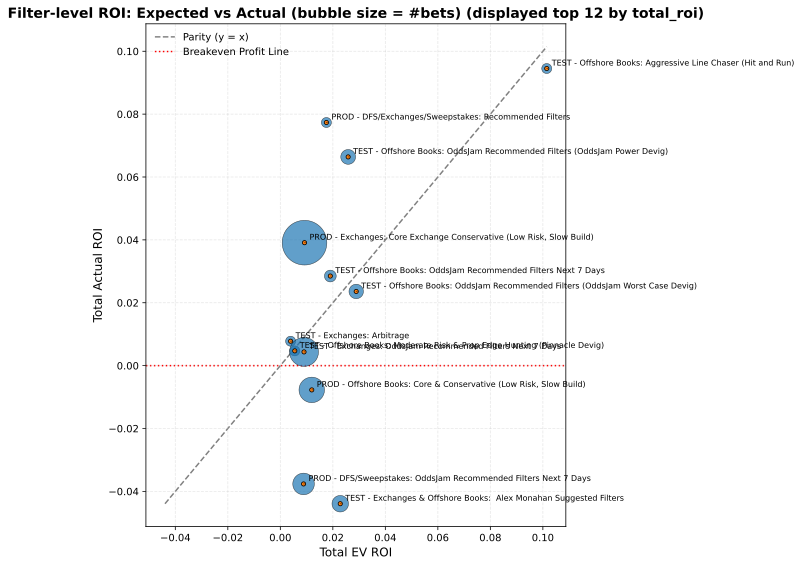

In [15]:
cfg = RoiScatterConfig(
    # display selection
    display_top_n=12,
    display_by_col="total_roi",  # ranked by this column ("total_stake", "total_bets", "total_roi", or "total_ev")
    display_filters=None,  # if set, overrides display_top_n and shows exactly those
    # annotation selection
    annotate_top_n=12,
    annotate_by_col="total_roi",  # "total_stake", "total_bets", "total_roi", or "total_ev"
    annotate_filters=None,  # if set, overrides top_n and annotates exactly those
    # outliers (farthest-from-cluster removed first)
    remove_outliers=False,  # If False, outlier_quantile, outlier_method, and outlier_apply are ignored
    outlier_quantile=0.99,  # Keep 99% closest to cluster
    outlier_method="distance",  # IMPORTANT: use distance-based outlier removal
    outlier_apply="both",  # ignored for distance; only used for axis_quantile
)

ax = plot_filter_roi_scatter(filter_summary_sorted, cfg=cfg)
plt.tight_layout()
plt.show()

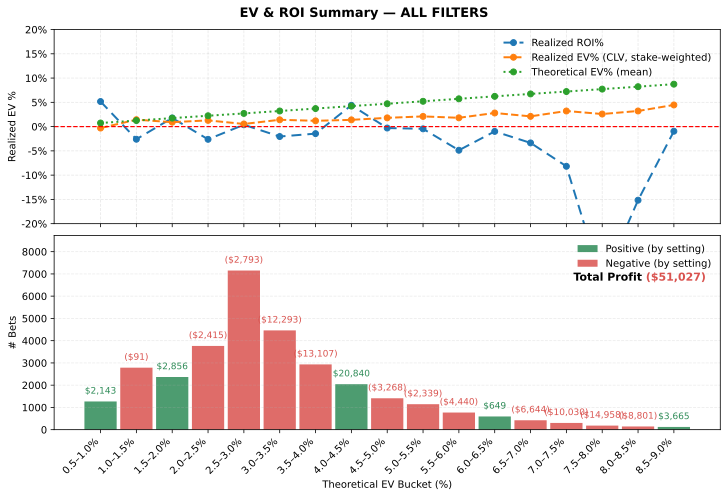

In [16]:
cfg = CombinedEVPlotConfig(
    bin_size=0.5,
    min_x_pct=0.0,
    max_x_pct=20.0,
    y_lim_pct=20,
    min_bets_per_bucket=100,
    show_ev_dollar_labels=True,
    clv_weight="stake",  # "stake" or "equal"
    bucket_edge="left",  # "left" or "right"
    bar_color_by="profit",  # so colors align with profit
    show_theoretical_ev_line=True,
)

combined_ev_summary_plot(
    df=df_filtered,
    filter_name=None,
    cfg=cfg,
    x_bucket="theoretical_ev",
)

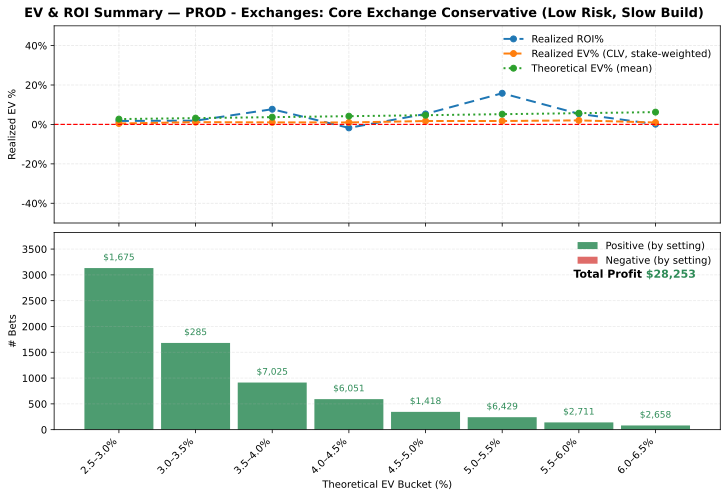

In [17]:
cfg = CombinedEVPlotConfig(
    bin_size=0.5,
    min_x_pct=2.0,
    max_x_pct=20.0,
    y_lim_pct=50,
    min_bets_per_bucket=50,
    show_ev_dollar_labels=True,
    clv_weight="stake",  # "stake" or "equal"
    bucket_edge="left",  # "left" or "right"
    bar_color_by="profit",  # so colors align with profit
    show_theoretical_ev_line=True,
)

combined_ev_summary_plot(
    df=df_filtered,
    filter_name="PROD - Exchanges: Core Exchange Conservative (Low Risk, Slow Build)",
    cfg=cfg,
    x_bucket="theoretical_ev",
)

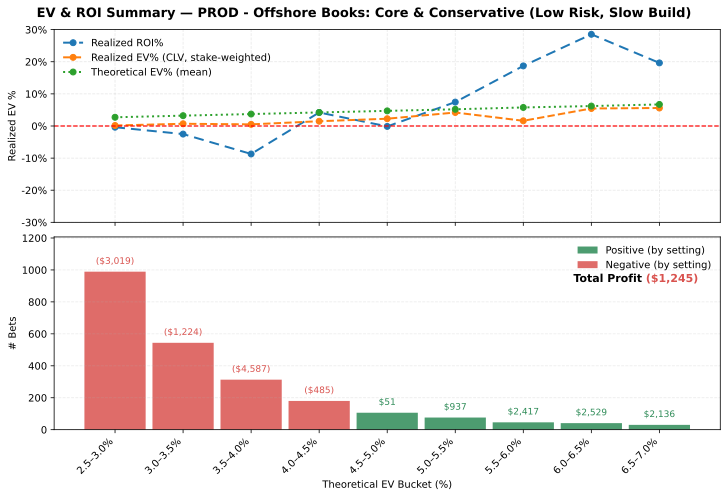

In [18]:
cfg = CombinedEVPlotConfig(
    bin_size=0.5,
    min_x_pct=2.0,
    max_x_pct=20.0,
    y_lim_pct=30,
    min_bets_per_bucket=25,
    show_ev_dollar_labels=True,
    clv_weight="stake",  # "stake" or "equal"
    bucket_edge="left",  # "left" or "right"
    bar_color_by="profit",  # so colors align with profit
    show_theoretical_ev_line=True,
)

combined_ev_summary_plot(
    df=df_filtered,
    filter_name="PROD - Offshore Books: Core & Conservative (Low Risk, Slow Build)",
    cfg=cfg,
    x_bucket="theoretical_ev",
)

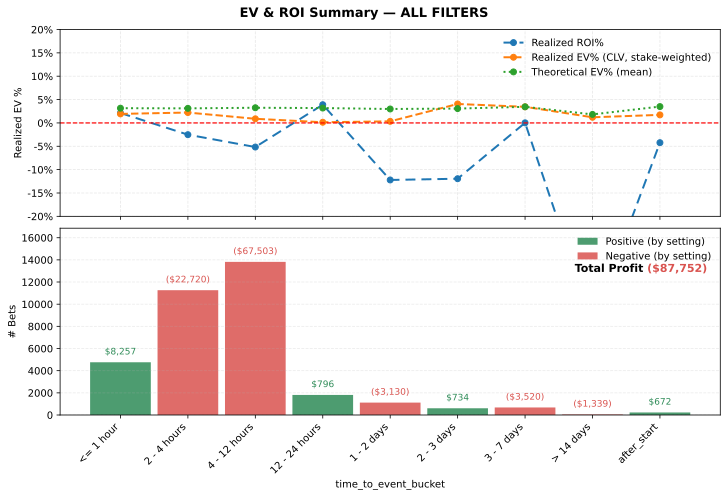

In [19]:
cfg = CombinedEVPlotConfig(
    bin_size=0.5,
    min_x_pct=2.0,
    max_x_pct=20.0,
    y_lim_pct=20,
    min_bets_per_bucket=25,
    show_ev_dollar_labels=True,
    clv_weight="stake",  # "stake" or "equal"
    bucket_edge="left",  # "left" or "right"
    bar_color_by="profit",  # so colors align with profit
    show_theoretical_ev_line=True,
)

combined_ev_summary_plot(
    df=df_filtered,
    filter_name=None,
    cfg=cfg,
    x_bucket="group_col",
    group_col="time_to_event_bucket",
    only_non_null_group=True,
)

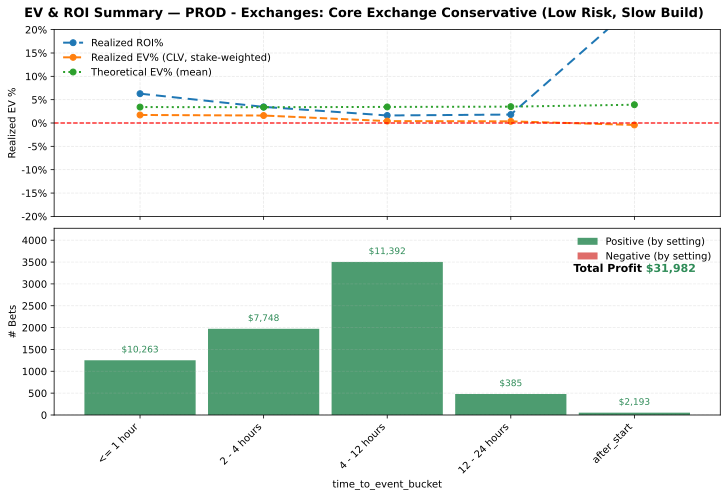

In [20]:
cfg = CombinedEVPlotConfig(
    bin_size=0.5,
    min_x_pct=2.0,
    max_x_pct=20.0,
    y_lim_pct=20,
    min_bets_per_bucket=25,
    show_ev_dollar_labels=True,
    clv_weight="stake",  # "stake" or "equal"
    bucket_edge="left",  # "left" or "right"
    bar_color_by="profit",  # so colors align with profit
    show_theoretical_ev_line=True,
)

combined_ev_summary_plot(
    df=df_filtered,
    filter_name="PROD - Exchanges: Core Exchange Conservative (Low Risk, Slow Build)",
    cfg=cfg,
    x_bucket="group_col",
    group_col="time_to_event_bucket",
    only_non_null_group=True,
)

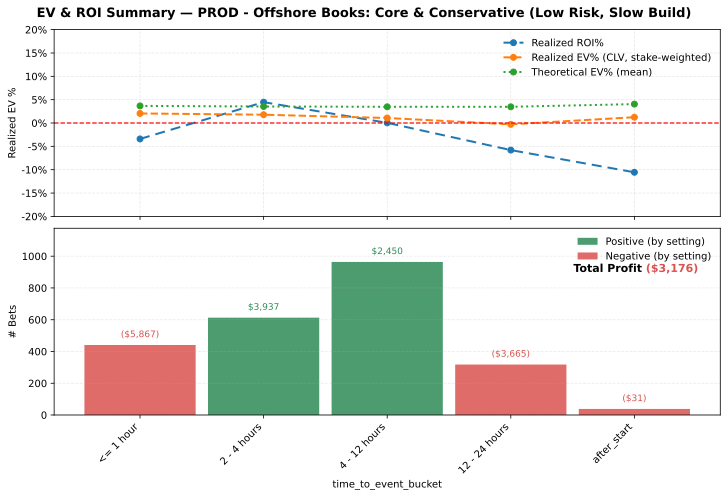

In [21]:
cfg = CombinedEVPlotConfig(
    bin_size=0.5,
    min_x_pct=2.0,
    max_x_pct=20.0,
    y_lim_pct=20,
    min_bets_per_bucket=25,
    show_ev_dollar_labels=True,
    clv_weight="stake",  # "stake" or "equal"
    bucket_edge="left",  # "left" or "right"
    bar_color_by="profit",  # so colors align with profit
    show_theoretical_ev_line=True,
)

combined_ev_summary_plot(
    df=df_filtered,
    filter_name="PROD - Offshore Books: Core & Conservative (Low Risk, Slow Build)",
    cfg=cfg,
    x_bucket="group_col",
    group_col="time_to_event_bucket",
    only_non_null_group=True,
)

## Liquidity Coverage + Bucketing
Checks liquidity availability and how bucketing behaves (including tag fallback behavior when numeric liquidity is missing).

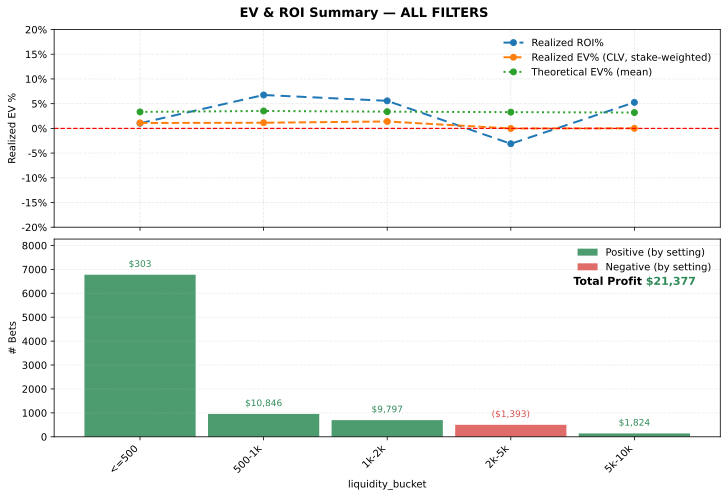

In [22]:
cfg = CombinedEVPlotConfig(
    bin_size=0.5,
    min_x_pct=2.0,
    max_x_pct=20.0,
    y_lim_pct=20,
    min_bets_per_bucket=100,
    show_ev_dollar_labels=True,
    clv_weight="stake",  # "stake" or "equal"
    bucket_edge="left",  # "left" or "right"
    bar_color_by="profit",  # so colors align with profit
    show_theoretical_ev_line=True,
)

combined_ev_summary_plot(
    df=df_filtered,
    filter_name=None,
    cfg=cfg,
    x_bucket="group_col",
    group_col="liquidity_bucket",
    only_non_null_group=True,
)

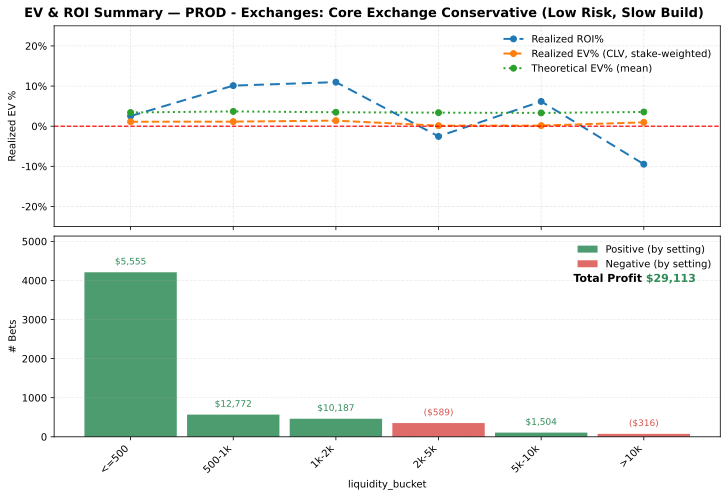

In [23]:
cfg = CombinedEVPlotConfig(
    bin_size=0.5,
    min_x_pct=2.0,
    max_x_pct=20.0,
    y_lim_pct=25,
    min_bets_per_bucket=50,
    show_ev_dollar_labels=True,
    clv_weight="stake",  # "stake" or "equal"
    bucket_edge="left",  # "left" or "right"
    bar_color_by="profit",  # so colors align with profit
    show_theoretical_ev_line=True,
)

combined_ev_summary_plot(
    df=df_filtered,
    filter_name="PROD - Exchanges: Core Exchange Conservative (Low Risk, Slow Build)",
    cfg=cfg,
    x_bucket="group_col",
    group_col="liquidity_bucket",
    only_non_null_group=True,
)

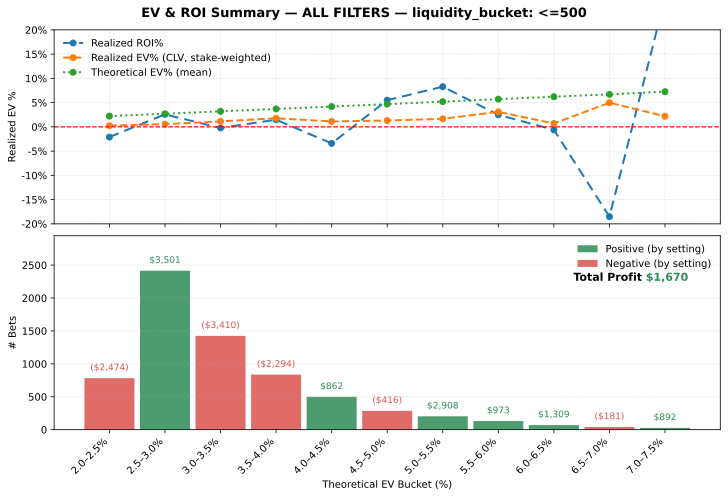

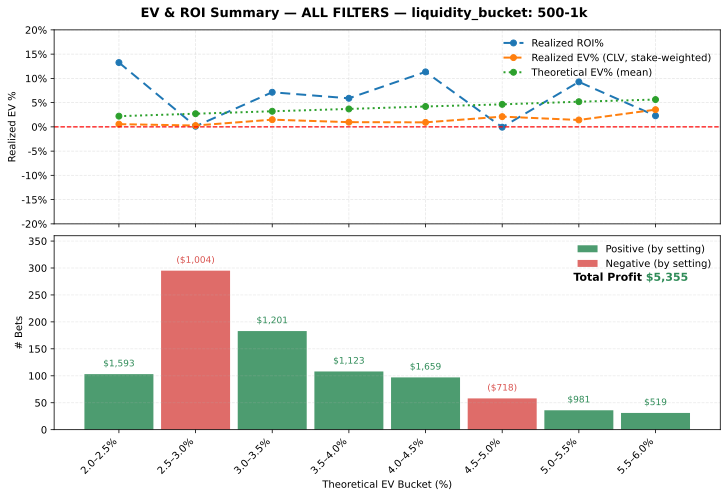

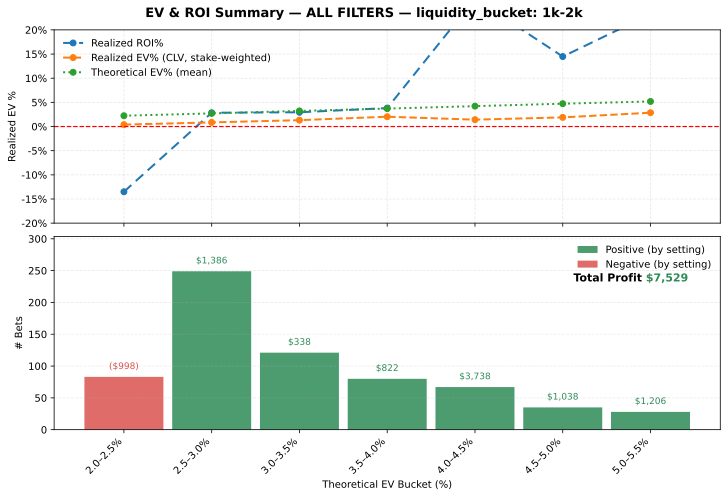

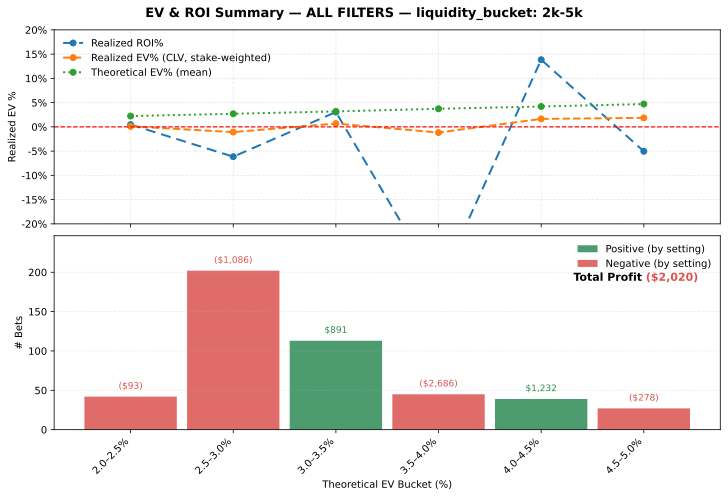

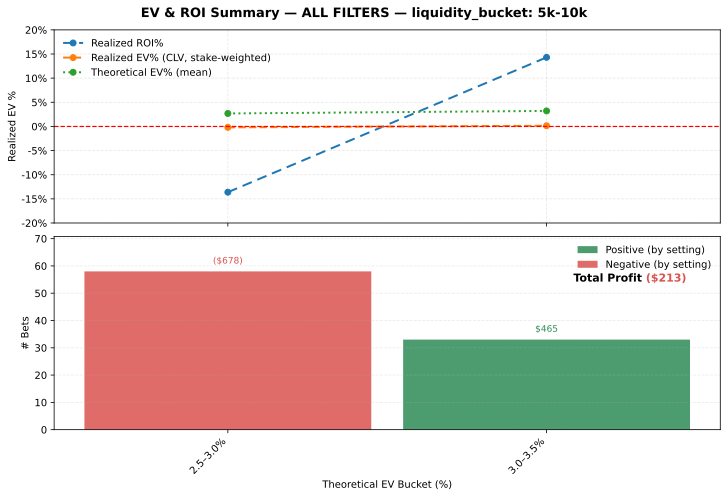

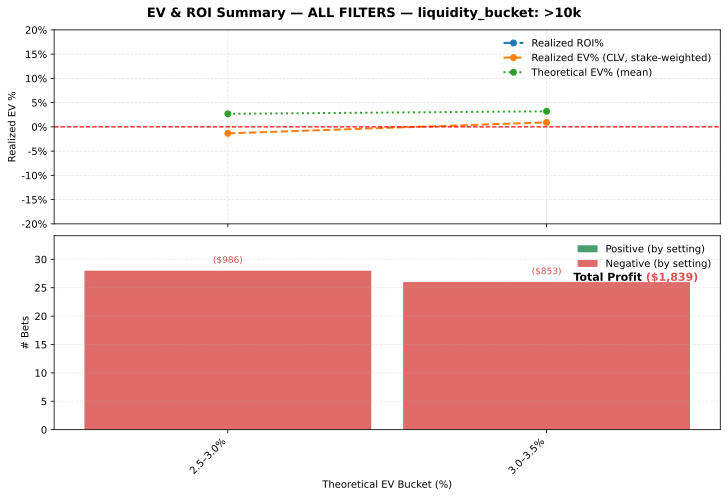

In [24]:
cfg = CombinedEVPlotConfig(
    bin_size=0.5,
    min_x_pct=2.0,
    max_x_pct=20.0,
    y_lim_pct=20,
    min_bets_per_bucket=25,
    show_ev_dollar_labels=True,
    clv_weight="stake",  # "stake" or "equal"
    bucket_edge="left",  # "left" or "right"
    bar_color_by="profit",  # so colors align with profit
    show_theoretical_ev_line=True,
)

combined_ev_summary_plot_faceted_by_group(
    df=df_filtered,
    filter_name=None,
    facet_col="liquidity_bucket",
    cfg=cfg,
    x_bucket="theoretical_ev",
    only_non_null_facet=True,
)

## Time-Series Diagnostics
Looks at cumulative profit, bet counts over time, and timing patterns to detect regime shifts and overfitting-by-period.

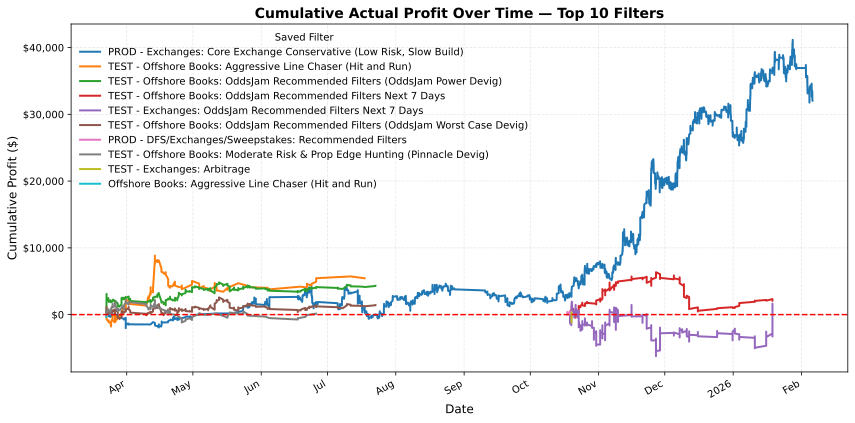

In [25]:
N = 10
cfg = CumProfitPlotConfig(resample=None, min_points_per_line=2)

plot_cum_profit_top_filters(
    df=df_filtered,
    filter_summary=filter_summary,
    top_n=10,
    sort_col="total_actual_profit",
    cfg=cfg,
)

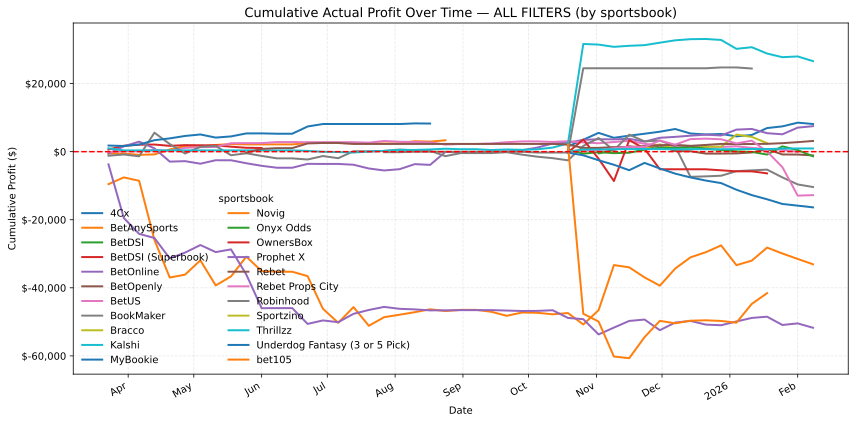

In [26]:
cfg = CumProfitByGroupPlotConfig(resample="W")

plot_cum_profit_by_group(
    df=df_filtered, group_col="sportsbook", filters=None, global_view=True, cfg=cfg
)

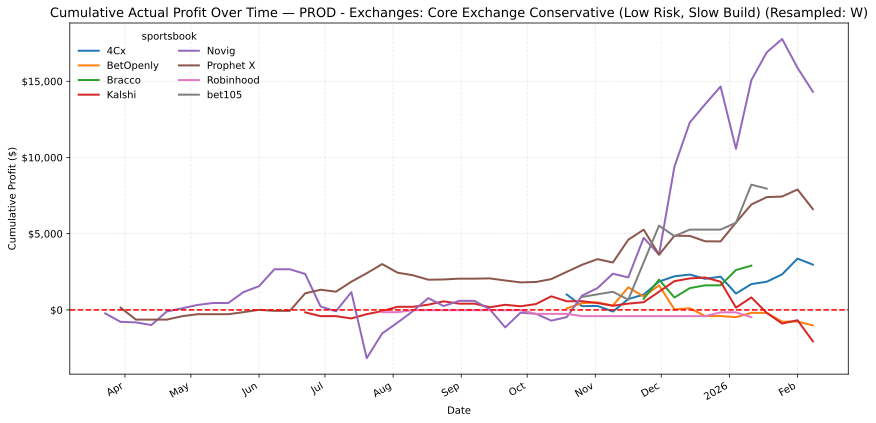

In [27]:
plot_cum_profit_by_group(
    df=df_filtered,
    group_col="sportsbook",
    filters="PROD - Exchanges: Core Exchange Conservative (Low Risk, Slow Build)",
    cfg=cfg,
)

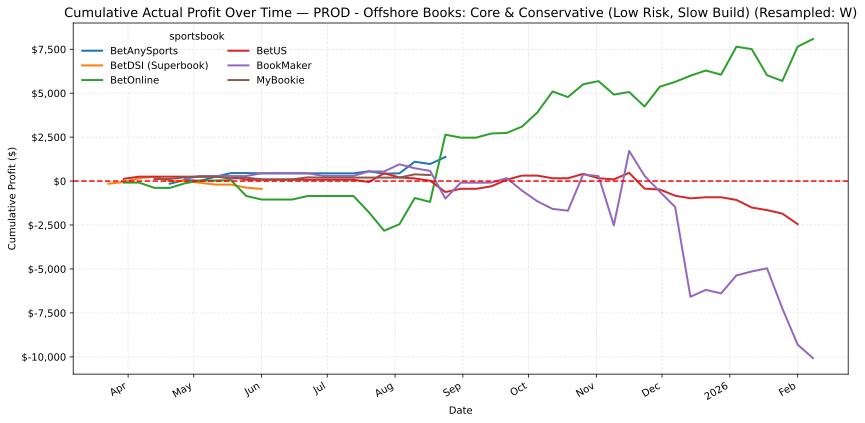

In [28]:
plot_cum_profit_by_group(
    df=df_filtered,
    group_col="sportsbook",
    filters="PROD - Offshore Books: Core & Conservative (Low Risk, Slow Build)",
    cfg=cfg,
)

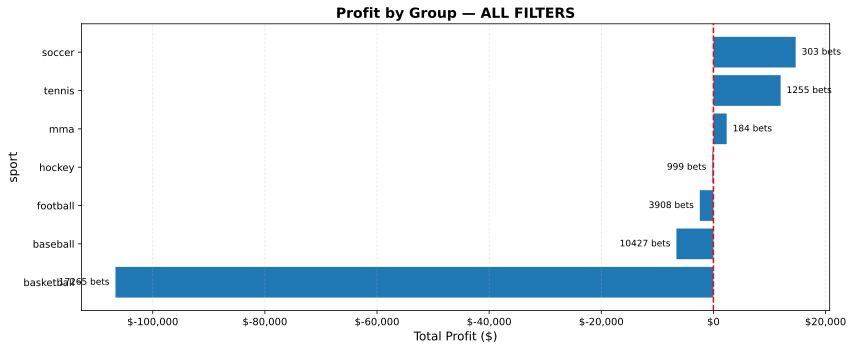

In [29]:
cfg = ProfitByGroupPlotConfig(min_bets_per_group=50, top_k=15, combine_filters=False)

plot_profit_by_group_for_filters(
    df=df_filtered, group_col="sport", filters=None, global_view=True, cfg=cfg
)

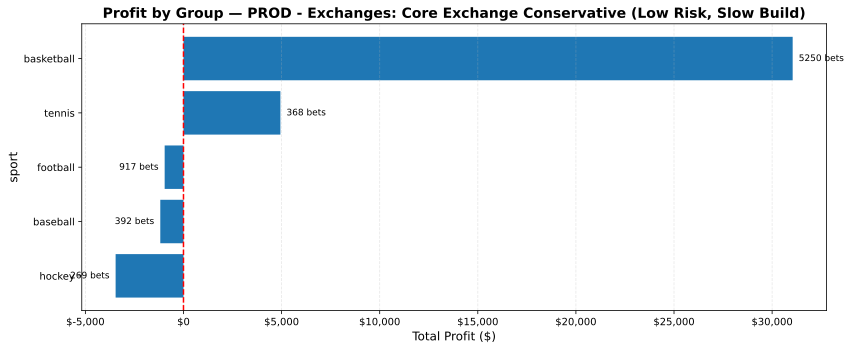

In [30]:
plot_profit_by_group_for_filters(
    df=df_filtered,
    group_col="sport",
    filters="PROD - Exchanges: Core Exchange Conservative (Low Risk, Slow Build)",
    cfg=cfg,
)

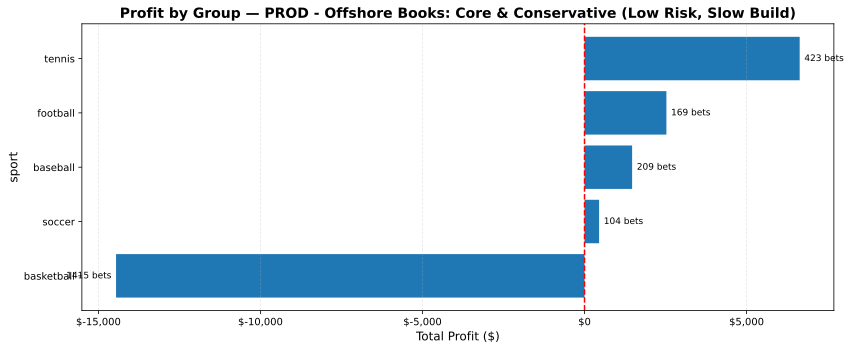

In [31]:
plot_profit_by_group_for_filters(
    df=df_filtered,
    group_col="sport",
    filters="PROD - Offshore Books: Core & Conservative (Low Risk, Slow Build)",
    cfg=cfg,
)

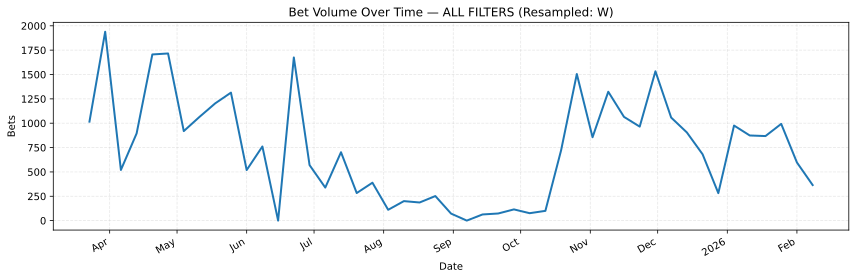

In [32]:
cfg = BetCountOverTimePlotConfig(resample="W")

plot_bet_count_over_time(df=df_filtered, filters=None, global_view=True, cfg=cfg)

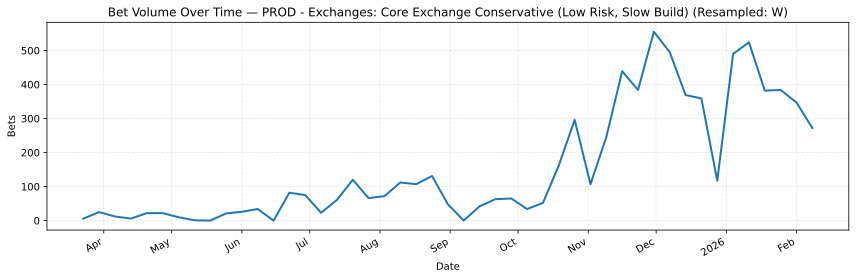

In [33]:
plot_bet_count_over_time(
    df=df_filtered,
    filters="PROD - Exchanges: Core Exchange Conservative (Low Risk, Slow Build)",
    cfg=cfg,
)

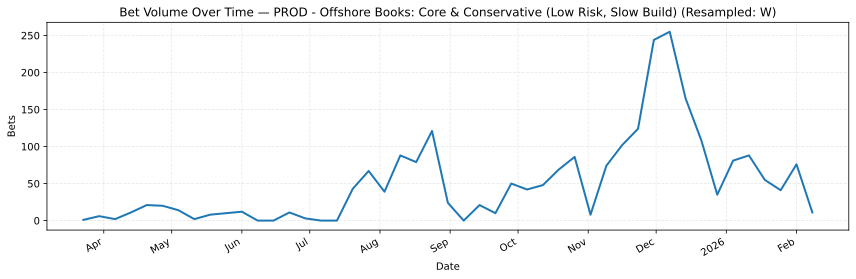

In [34]:
plot_bet_count_over_time(
    df=df_filtered,
    filters="PROD - Offshore Books: Core & Conservative (Low Risk, Slow Build)",
    cfg=cfg,
)

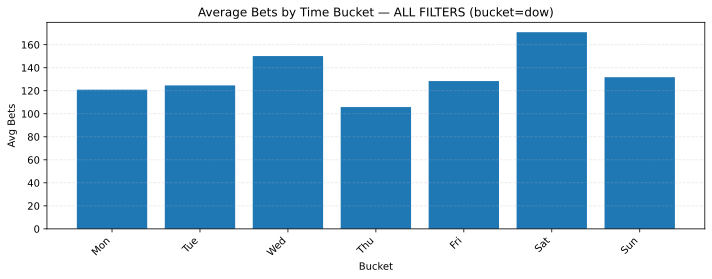

In [35]:
cfg = AvgBetsByTimeBucketPlotConfig(bucket="dow")

plot_avg_bets_by_time_bucket(df=df_filtered, filters=None, global_view=True, cfg=cfg)

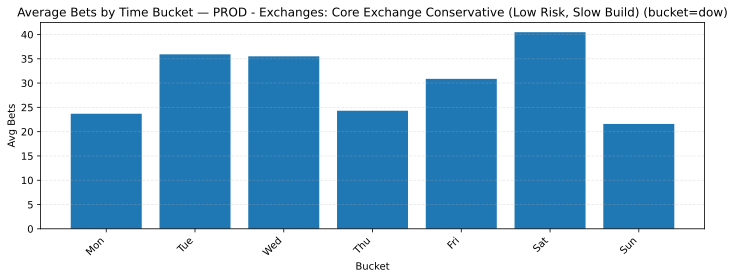

In [36]:
plot_avg_bets_by_time_bucket(
    df=df_filtered,
    filters="PROD - Exchanges: Core Exchange Conservative (Low Risk, Slow Build)",
    cfg=cfg,
)

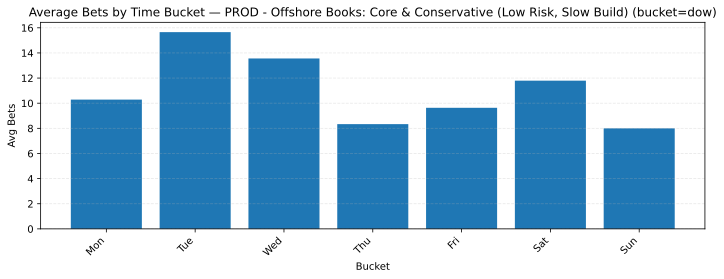

In [37]:
plot_avg_bets_by_time_bucket(
    df=df_filtered,
    filters="PROD - Offshore Books: Core & Conservative (Low Risk, Slow Build)",
    cfg=cfg,
)

## Data Readiness Sign-Off (Notebook 01)
Prints a compact “ship/no-ship” summary:
timestamp health, core field validation, duplicates, liquidity coverage, and known caveats.

In [38]:
# --- Decision Outputs: Data readiness sign-off + caveats ---


def _pct(x: float) -> str:
    return f"{x * 100:.2f}%"


def _get(obj, key, default=None):
    if isinstance(obj, dict):
        return obj.get(key, default)
    return getattr(obj, key, default)


print("=== DATA READINESS SIGN-OFF (Notebook 01) ===")
print(f"Rows (preprocessed): {len(df_filtered):,}")
print()

# Timestamp coverage + assumption
ts_ok = (
    df_filtered["created_at_et"].notna().mean()
    if "created_at_et" in df_filtered.columns
    else np.nan
)
print("Timestamp standardization:")
print("  created_at_et present:", "created_at_et" in df_filtered.columns)
print("  created_at_et non-null rate:", _pct(float(ts_ok)) if pd.notna(ts_ok) else "NA")
print("  Assumption for tz-naive created_at: localized as America/New_York (ET)")
print()

# Core field validation snapshot (from artifact JSON if loaded)
print("Core field validation (artifact):")
missing_rate = _get(filt_core, "missing_rate", {}) or {}
impossible_counts = _get(filt_core, "impossible_counts", {}) or {}

if not missing_rate and not impossible_counts:
    print("  field-validation artifact not loaded (check artifacts_dir + filename pattern).")
else:
    for k, v in missing_rate.items():
        print(f"  missing_rate[{k}] = {_pct(float(v))}")
    for k, v in impossible_counts.items():
        print(f"  impossible[{k}] = {int(v):,}")
print()

# Duplicate characteristics
print("Duplicate audit summary:")
if "dupe_report" in globals():
    display(dupe_report)
else:
    print("  dupe_report not found (did you run the duplicate audit cell?)")
print()

# Liquidity missingness + tag fallback usage
print("Liquidity:")
liq_col_present = "liquidity" in df_filtered.columns
out_bucket_col = "liquidity_bucket"
tag_col = "tags"

if liq_col_present:
    liq_num = pd.to_numeric(df_filtered["liquidity"], errors="coerce")
    liq_miss = float(liq_num.isna().mean())
    print("  liquidity missing rate:", _pct(liq_miss))
    print("  Note: missing liquidity is expected for some sportsbooks/older exports.")
else:
    liq_num = pd.Series([pd.NA] * len(df_filtered), index=df_filtered.index, dtype="float")
    print("  No liquidity column in this export (treating as all-missing).")

# Tag-backed bucketing usage attribution (best-effort)
if out_bucket_col in df_filtered.columns and tag_col in df_filtered.columns:
    tags = df_filtered[tag_col].astype("string")
    has_liq_tag = tags.str.contains("Liq", na=False)

    used_tag_for_bucket = liq_num.isna() & has_liq_tag & df_filtered[out_bucket_col].notna()

    n_rows = int(len(df_filtered))
    n_used = int(used_tag_for_bucket.sum())
    used_rate = (n_used / n_rows) if n_rows else 0.0

    n_liq_missing = int(liq_num.isna().sum()) if liq_col_present else n_rows
    missing_fill_rate = (n_used / n_liq_missing) if n_liq_missing else 0.0

    n_has_tag = int(has_liq_tag.sum())
    tag_rate = (n_has_tag / n_rows) if n_rows else 0.0

    print("  liquidity bucket source summary (best-effort):")
    print(f"    rows bucketed via tag fallback: {n_used:,} ({_pct(used_rate)})")
    print(
        f"    among rows with missing numeric liquidity: {n_used:,}/{n_liq_missing:,} ({_pct(missing_fill_rate)})"
    )
    print(f"    rows with any Liq-tag: {n_has_tag:,} ({_pct(tag_rate)})")
else:
    missing_bits = []
    if out_bucket_col not in df_filtered.columns:
        missing_bits.append(out_bucket_col)
    if tag_col not in df_filtered.columns:
        missing_bits.append(tag_col)
    print(f"  liquidity tag fallback usage: NA (missing {', '.join(missing_bits)})")

print()

# Optional: show settlement inference summary if loaded
if "settled_meta" in globals() and isinstance(settled_meta, dict) and settled_meta:
    print("Settlement inference (artifact):")
    print(
        "  exclude_statuses_for_settled_inference:",
        settled_meta.get("exclude_statuses_for_settled_inference"),
    )
    print("  exclude_statuses_from_processed:", settled_meta.get("exclude_statuses_from_processed"))
    print("  n_rows_processed:", settled_meta.get("n_rows_processed"))
    print("  n_rows_settled:", settled_meta.get("n_rows_settled"))
    print("  settled_statuses:", settled_meta.get("settled_statuses"))
    print()

print("=== KNOWN DATA CAVEATS ===")
print(
    "- created_at was tz-naive in the CSV; we localized it to ET (America/New_York). If OddsJam export timezone differs, timing analyses will shift."
)
print(
    "- We do NOT deduplicate by default in Notebook 01 (keeps realized ROI/true profit faithful to execution)."
)
print(
    "- Duplicate rows may include export artifacts and/or true repeated firing of the same opportunity; see dupe_report and example clusters."
)
print(
    "- Liquidity is allowed to be NULL; buckets apply when liquidity is numeric OR when a Liq-tag is present (fallback)."
)
print(
    "- Any downstream modeling notebook should strongly consider opportunity-level dedupe/aggregation + group-aware splits to prevent leakage."
)

=== DATA READINESS SIGN-OFF (Notebook 01) ===
Rows (preprocessed): 34,348

Timestamp standardization:
  created_at_et present: True
  created_at_et non-null rate: 100.00%
  Assumption for tz-naive created_at: localized as America/New_York (ET)

Core field validation (artifact):
  missing_rate[stake] = 0.00%
  missing_rate[odds] = 0.00%
  missing_rate[bet_profit] = 0.00%
  impossible[stake<=0] = 0
  impossible[odds==0] = 0
  impossible[bet_profit is inf] = 0

Duplicate audit summary:


,key_name,n_rows,n_dupe_rows,dupe_row_rate,n_unique,note
0,sportsbook | created_at_et | stake | odds | bet_profit,36529,630.0,0.017247,36195.0,NaN
1,id,36529,NaN,NaN,NaN,missing cols: ['id']
2,bet_id,36529,NaN,NaN,NaN,missing cols: ['bet_id']
3,sportsbook | event | market | bet_name | odds | stake,36529,NaN,NaN,NaN,"missing cols: ['event', 'market']"
4,sportsbook | event_id | market | bet_name | odds | stake,36529,NaN,NaN,NaN,"missing cols: ['event_id', 'market']"
5,sportsbook | league | sport | market | bet_name | odds | stake,36529,NaN,NaN,NaN,missing cols: ['market']
6,sportsbook | bet_name | market | odds | stake | created_at_et,36529,NaN,NaN,NaN,missing cols: ['market']
7,sportsbook | bet_name | market | odds | stake,36529,NaN,NaN,NaN,missing cols: ['market']



Liquidity:
  liquidity missing rate: 100.00%
  Note: missing liquidity is expected for some sportsbooks/older exports.
  liquidity bucket source summary (best-effort):
    rows bucketed via tag fallback: 9,155 (26.65%)
    among rows with missing numeric liquidity: 9,155/34,348 (26.65%)
    rows with any Liq-tag: 9,155 (26.65%)

Settlement inference (artifact):
  exclude_statuses_for_settled_inference: ['open', 'pending', 'unsettled']
  exclude_statuses_from_processed: True
  n_rows_processed: 34348
  n_rows_settled: 34348
  settled_statuses: ['lost', 'won', 'refunded']

=== KNOWN DATA CAVEATS ===
- created_at was tz-naive in the CSV; we localized it to ET (America/New_York). If OddsJam export timezone differs, timing analyses will shift.
- We do NOT deduplicate by default in Notebook 01 (keeps realized ROI/true profit faithful to execution).
- Duplicate rows may include export artifacts and/or true repeated firing of the same opportunity; see dupe_report and example clusters.
- Liqui